# Simple Naive Bayes Classifier from Scratch

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## Data Load and Inspection

In [2]:
mushroom_df = pd.read_csv('mushrooms.csv')

In [3]:
mushroom_df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [4]:
unique_classes = mushroom_df['class'].unique()
unique_classes

array(['p', 'e'], dtype=object)

/opt/homebrew/Caskroom/miniforge/base/envs/nasa/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


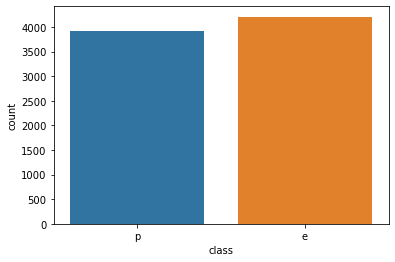

In [5]:
sns.countplot(mushroom_df['class'])
plt.show()

In [6]:
X = mushroom_df.drop('class', axis=1)
y = mushroom_df['class']
feature_columns = X.columns

In [7]:
#stratify 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=125)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [8]:
print("Number of train and test data: ", len(X_train), len(X_test))

Number of train and test data:  5686 2438


/var/folders/lc/0svhcdcn6pd728qrzry78cj00000gn/T/ipykernel_40316/104829099.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


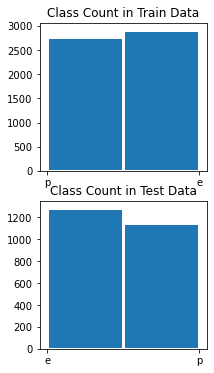

In [9]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(3,6))

ax1.hist(y_train, bins=2, linewidth=3, edgecolor="white")
ax1.set_title("Class Count in Train Data")
ax2.hist(y_test, bins=2, linewidth=3, edgecolor="white")
ax2.set_title("Class Count in Test Data")

fig.show()

## Naive Bayes Predictor

In [10]:
def likelihood_calc(train_data, train_labels, feature_columns, unique_classes):
    '''Here we'll calculate the likelihood and record the probabilities in a copy of the
       training dataframe. We'll be returning that dataframe at the end of the func.
    '''
    
    train_record = train_data.copy()
    
    #Iterate through the classes and calculate the likelihood for each class.
    for cls_idx, cls_name in enumerate(unique_classes):
        
        for feat_idx, feat_name in enumerate(feature_columns):
            
            #filter the training data based on the class and the column.
            filtered_train_df = train_data.loc[train_labels == cls_name, feat_name]
            
            #identify the unique values and the count of those values from the column.
            unique, count = np.unique(filtered_train_df, return_counts=True)
            
            #calculate the probability & record them in a dictionary (count/total class data)
            count_dict = dict(zip(unique, count/len(filtered_train_df)))
            
            #let's substitute the values for the probabilities.
            likelihood_values = train_record.loc[train_labels == cls_name, feat_name]\
                                    .map(count_dict)
            indices = likelihood_values.index.tolist()
            values = likelihood_values.values
            
            #record the probabilities in the train record dataframe.
            train_record.loc[indices, feat_name] = values
    
    #for convenience, we'll append the actual class labels in the record.
    train_record['class'] = train_labels
            
    return train_record

In [11]:
def class_prior_calc(unique_classes, train_record):
    '''Calculation of the prior. We'll record the prior values in the train record dataframe
       in a separate column. We'll also add the actual class column for convenience.
    '''
    
    train_record['class_prior'] = np.nan
    
    for cls_idx, cls_name in enumerate(unique_classes):
        
        total_cls_num = train_record[train_record['class']==cls_name].shape[0]
        cls_probability = total_cls_num/train_record.shape[0]
        train_record.loc[train_record['class']==cls_name, 'class_prior'] = cls_probability
    
    return train_record

In [12]:
def cross_reference(test_data, train_record, train_data):
    '''Uses the train record to find the location of the features and cross-reference
       to the record to find the likelihood.
    '''
    #compare the test column values with the train column values and find its index.
    indices = train_data.index[train_data.isin([test_data])].tolist()
    #this occurs if the feature is not present in the train data.
    if len(indices) == 0:
        return 0
    
    #we need the [0] because the train data most likely contain duplicates and therefore
    #it returns a list of indices. We only need one since all of them are duplicates.
    likelihood_prob = train_record.loc[indices[0]] 
    
    return likelihood_prob


def calc_posterior_prob_per_row(row, cls_name, train_record):
    '''Given the row data of likelihood probabilities, use the class prior from train record
       to calculate the posterior probability of a class.
    '''
    
    #filter the class that we want and get its class prior.
    #the result of this line will most likely be a huge single-column dataframe with
    #duplicate values.
    class_prior = train_record[train_record['class'] == cls_name]['class_prior']
    class_prior = class_prior.tolist()[0] #hence the indexing.
    
    likelihood_probs_product = np.prod(row) #multiply the likelihoods of the features.
    
    posterior_prob = class_prior * likelihood_probs_product #as per our derived N.B. equation
    
    return posterior_prob
    
    

def calc_posterior_prob(test_data, unique_classes, feature_columns, train_data,
                            train_record):
    '''Calculate the posterior probability of the test data.
    '''
    
    #we're gonna need a copy of the test dataframe for each class.
    test_records = {}
    
    #cross-refer and identify the likelihood probabilities.
    for cls_idx, cls_name in enumerate(unique_classes):
        
        test_records[cls_name] = test_data.copy()
        
        #filter the train data and train record according to the classes.
        train_data_class_filtered = train_data.loc[train_record['class'] == cls_name]
        train_record_class_filtered = train_record.loc[train_record['class'] == cls_name]
        
        for _, feat_name in enumerate(feature_columns):
            
            #extract the column data from all 3 dataframes.
            test_data_column = test_data[feat_name]
            train_data_column = train_data_class_filtered[feat_name]
            train_record_column = train_record_class_filtered[feat_name]
            
            #We're going to identify whether or not the value exist in the train data
            #and if it is, we'll cross-reference for it's likelihood probability from
            #the train record df. Else, return 0.
            test_records[cls_name][feat_name] = test_data_column.apply(
                                                        lambda x:cross_reference(
                                                        test_data=x,
                                                        train_record=train_record_column,
                                                        train_data=train_data_column))
    
    #calculate the posterior probability.
    for cls_idx, cls_name in enumerate(unique_classes):
        
        test_records[cls_name]['posterior'] = test_records[cls_name].apply(
                                                    lambda x: calc_posterior_prob_per_row(
                                                        row=x, cls_name=cls_name, 
                                                        train_record=train_record), axis=1)
        
            
    return test_records

In [13]:
def get_max_class_prediction(test_records, unique_classes):
    '''Given the posterior probabilities of all classes, find the highest prob.
    '''
    predictions = {}
    
    for cls_idx, cls_name in enumerate(unique_classes):
        
        predictions[cls_name] = test_records[cls_name]['posterior']
    
    predictions = pd.DataFrame.from_dict(predictions)
    max_preds = predictions.idxmax(axis=1)
    
    return max_preds

In [14]:
def check_accuracy(predictions, actual_labels):
    '''Compare the predictions with the test labels.
    '''
    
    comparison = predictions == actual_labels
    accuracy = comparison.sum()/len(actual_labels) * 100
    
    return accuracy

In [15]:
train_record = likelihood_calc(train_data=X_train,
                train_labels=y_train,
                feature_columns=feature_columns,
                unique_classes=unique_classes)

In [16]:
train_record = class_prior_calc(unique_classes=unique_classes,
                                train_record=train_record)

In [17]:
train_record.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class,class_prior
0,0.154736,0.36081,0.22162,0.836587,0.553145,0.994577,0.969631,0.564353,0.43167,0.507954,...,0.320318,1.0,0.997469,0.971439,0.443601,0.455531,0.718727,0.152928,p,0.486458
1,0.396602,0.36081,0.22162,0.836587,0.139913,0.994577,0.969631,0.564353,0.43167,0.507954,...,0.436732,1.0,0.997469,0.971439,0.443601,0.455531,0.718727,0.249819,p,0.486458
2,0.154736,0.36081,0.255965,0.836587,0.553145,0.994577,0.969631,0.564353,0.43167,0.507954,...,0.436732,1.0,0.997469,0.971439,0.443601,0.455531,0.718727,0.249819,p,0.486458
3,0.013015,0.444685,0.023138,0.163413,0.032899,0.994577,0.969631,0.435647,0.006508,0.492046,...,0.436732,1.0,0.997469,0.0188,0.215835,0.0188,0.718727,0.008315,p,0.486458
4,0.388014,0.358219,0.300685,0.655479,0.807877,0.953767,0.715411,0.933904,0.205137,0.614384,...,0.635616,1.0,0.953767,0.87363,0.74863,0.421918,0.278425,0.445205,e,0.513542


In [18]:
test_records = calc_posterior_prob(test_data=X_test, unique_classes=unique_classes,
                    feature_columns=feature_columns, 
                   train_data=X_train,
                   train_record=train_record)

In [19]:
predictions = get_max_class_prediction(test_records=test_records,
                                       unique_classes=unique_classes)

In [20]:
predictions.head()

0    e
1    p
2    e
3    e
4    e
dtype: object

In [23]:
accuracy = check_accuracy(predictions=predictions,
                          actual_labels=y_test)

In [24]:
print("The accuracy of the predictions is: ", accuracy)

The accuracy of the predictions is:  99.79491386382281
